In [1]:
# comand to convert the script to a pdf: jupyter nbconvert @sence_exercice_1.ipynb --to pdf --TagRemovePreprocessor.remove_input_tags='["r"]'

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display 

<center>Mathis</center>

# Atmospheric remote sensing Exercise 1

## Task 0 Impact of airmass in various altitudes under different incident angels.

The airmass under a incident angle $\theta_0$ is still $m = \frac{1}{cos(\theta)}$. To find $\theta$ we use the law of sines:

$\frac{r+h}{sin(180-\theta_0)} = \frac{r}{sin(\theta)}$

Plugging in the numbers given on the exercice sheet we get:

In [2]:
h = np.array([1,5,20])
theta_0 = np.array([45, 80, 85])

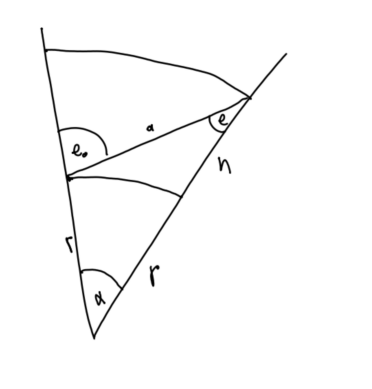

In [3]:
image = plt.imread('skizze.png')
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
r = 6300
def get_airmass(h, theta_0):
    theta_0 = np.radians(theta_0)
    theta = np.arcsin(r * np.sin(np.pi-theta_0)/(r+h))
    airmass = 1/np.cos(theta)
    return airmass

In [5]:
results = []

# Calculate airmass for each combination of elevation and angle
for elevation in h:
    for angle in theta_0:
        airmass = get_airmass(elevation, angle)
        results.append({
            'Elevation (km)': elevation,
            'Solar Zenith Angle (°)': angle,
            'Airmass (m)': round(airmass, 2)  # Round to 2 decimal places
        })

# Create a DataFrame
pd.set_option('display.float_format', '{:.2f}'.format)

df = pd.DataFrame(results)

# Pivot the DataFrame to have elevations as rows and angles as columns
pivot_df = df.pivot(columns='Elevation (km)', index='Solar Zenith Angle (°)', values='Airmass (m)')

# Display the pivot DataFrame
print('Air mass at different elevations under different zenit angles:')
display(pivot_df)

Air mass at different elevations under different zenit angles:


Elevation (km),1,5,20
Solar Zenith Angle (°),,,
45,1.41,1.41,1.41
80,5.73,5.62,5.25
85,11.24,10.44,8.49


From the Beer-Lambert law $I = I_o \exp(- \tau m)$ we find $\tau = \frac{\ln\frac{I_0}{I}}{m}$. The relative deviation only dependent on the airmass.

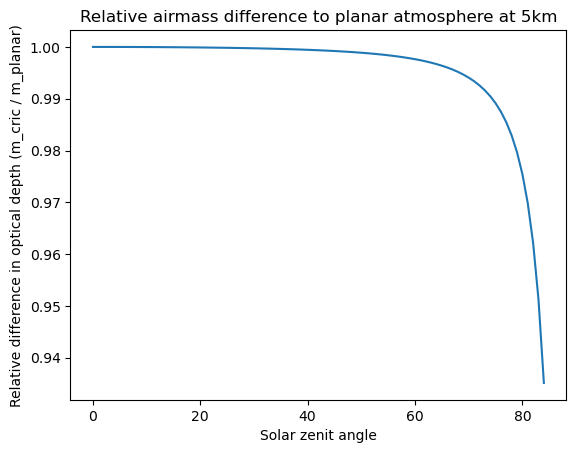

In [6]:
angels = np.arange(0,85)
plt.plot(angels, get_airmass(5,angels)* np.cos(np.radians(angels)))
plt.title('Relative airmass difference to planar atmosphere at 5km')
plt.xlabel('Solar zenit angle')
plt.ylabel('Relative difference in optical depth (m_cric / m_planar)')
plt.show()

## Task 1 Sensitivity to total column ozone

For this experiment we use the uvspec solver of libradtrans to simulate a atmosphere with different ozon amounts. All experiments were conducted with a solar zenit angel of 40°, 10mm of water, and a albedo of 0.2. 

The spectral ranges that are affected the most are between 280 nm and 350 nm and between 500 nm and 700 nm.

In [7]:
def erythema_spectrum(wavelengths):
    """
    Calculate the CIE erythema action spectrum for given wavelengths.
    
    Args:
        wavelengths: numpy array of wavelengths in nanometers
    
    Returns:
        numpy array of corresponding action spectrum values
    """
    spectrum = np.zeros_like(wavelengths, dtype=float)
    
    # Define the conditions according to the CIE standard
    mask1 = (wavelengths >= 250) & (wavelengths <= 298)
    mask2 = (wavelengths > 298) & (wavelengths <= 328)
    mask3 = (wavelengths > 328) & (wavelengths <= 400)
    
    # Apply the different formulas for each wavelength range
    spectrum[mask1] = 1.0
    spectrum[mask2] = 10.0 ** (0.094 * (298 - wavelengths[mask2]))
    spectrum[mask3] = 10.0 ** (0.015 * (140 - wavelengths[mask3]))
    
    # Set values outside the defined ranges to 0
    # (wavelengths < 250 or wavelengths > 400)
    
    return spectrum

# Generate wavelength array from 99 to 1000 nm


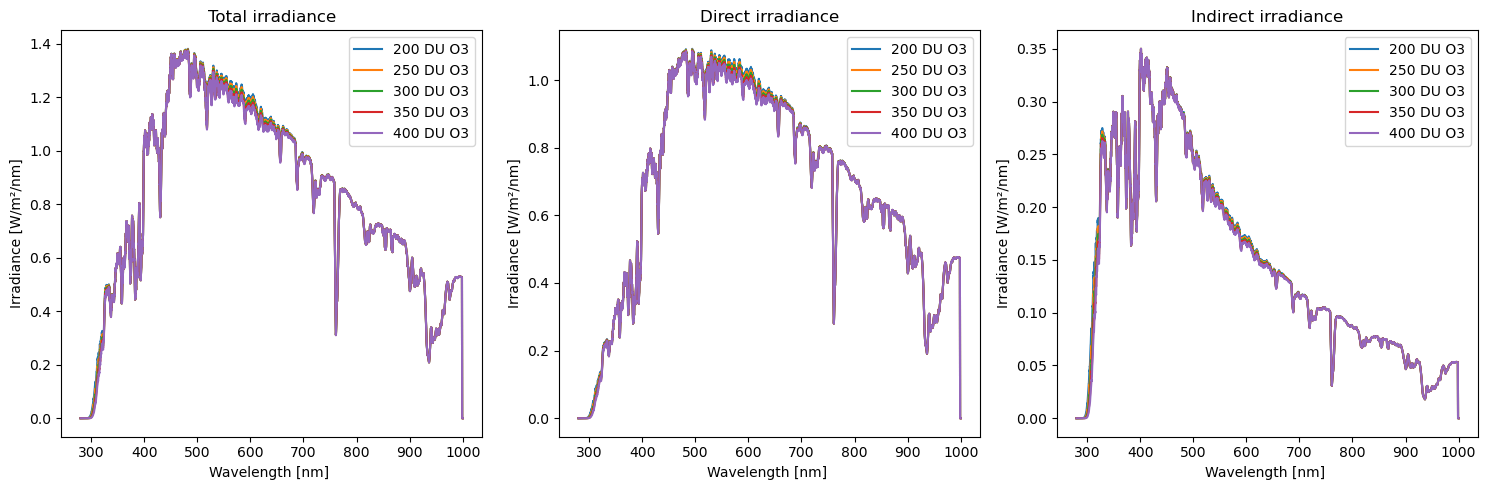

In [16]:
# Read all files
data_list = []
output_path = Path('task1/output')

for file_path in sorted(output_path.glob('*')):
    if file_path.is_file():
        # Load data from file
        data = np.loadtxt(file_path)
        data_list.append(data)

# Stack into 3D array (batch, row, column)
data = np.stack(data_list)
# adjust the unit of the values to [W/m²/nm]
data[:,:,1:4]*= 1E-3
# Now data_array.shape will be (n_files, n_rows, n_columns)

data_trans = np.zeros_like(data)

# window size that is used to smooth the curves for better readibility.
window = 31

# Parameters for the legend and title of the plots
ozon_values = [200, 250, 300, 350,400]
channel_titles = ['','Total irradiance', 'Direct irradiance', 'Indirect irradiance']
plt.figure(figsize=(15, 5))

# Loop through channels
for c in range(3):
    # Create subplot in position c+1
    plt.subplot(1, 3, c+1)
    c = c+1
    for i in range(data.shape[0]):
        # smooth the data
        data_trans[i,:,c] = np.pad(np.convolve(data[i,:,c], np.ones(window)/window, mode='valid'), 
            pad_width=int(np.floor(window/2))
        )
        plt.plot(data[i,:,0], data_trans[i,:,c], 
                label=f'{ozon_values[i]} DU O3')
    
    plt.title(f'{channel_titles[c]}')
    plt.xlabel('Wavelength [nm] ')
    plt.ylabel('Irradiance [W/m²/nm]')
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In both cases the indirect irradiance is the main contributor to the reduced irradiance. For the wavelength range between 280 nm and 380 nm we find that an increse of Ozon higher then 300 du does not lead to lower irradiance. This result does not align with what we expect and contradicts the findings of the erythemal analysis. One explenation is that the value differences get to small and rounding errors are to large to distinguish anymore.

In [34]:
pd.set_option('display.float_format', '{:.3}'.format)

print('Table of integrated irradiance differences between 280nm and 380 nm')
res = np.sum(data[:,0:100,1:4]-data[0,0:100,1:4], axis=1)
df_300 = pd.DataFrame(res, columns=['Total Irradiance difference [w/m²]', 'Direct', 'Indirect'], index= ozon_values)
df_300.index.name = 'Ozone content [du]'
display(df_300)
print('\n')
print('Table of integrated irradiance differences between 500 nm and 700 nm')
res = np.sum(data[:,220:420,1:4]-data[0,220:420,1:4], axis=1)
df_600 = pd.DataFrame(res, columns=['Total Irradiance difference [w/m²]', 'Direct', 'Indirect'], index= ozon_values)
df_600.index.name = 'Ozone content [du]'
display(df_600)

Table of integrated irradiance differences between 280nm and 380 nm


,Total Irradiance difference [w/m²],Direct,Indirect
Ozone content [du],,,
200,0.0,0.0,0.0
250,-7.48e-05,-2.83e-05,-4.66e-05
300,-7.95e-05,-3.01e-05,-4.95e-05
350,-7.95e-05,-3.01e-05,-4.95e-05
400,-7.95e-05,-3.01e-05,-4.95e-05




Table of integrated irradiance differences between 500 nm and 700 nm


,Total Irradiance difference [w/m²],Direct,Indirect
Ozone content [du],,,
200,0.0,0.0,0.0
250,-4.07,-1.48,-2.59
300,-7.47,-2.73,-4.74
350,-10.3,-3.81,-6.53
400,-12.8,-4.74,-8.06


## For the next subtask we analyse the erythemal impact of uv radiation.

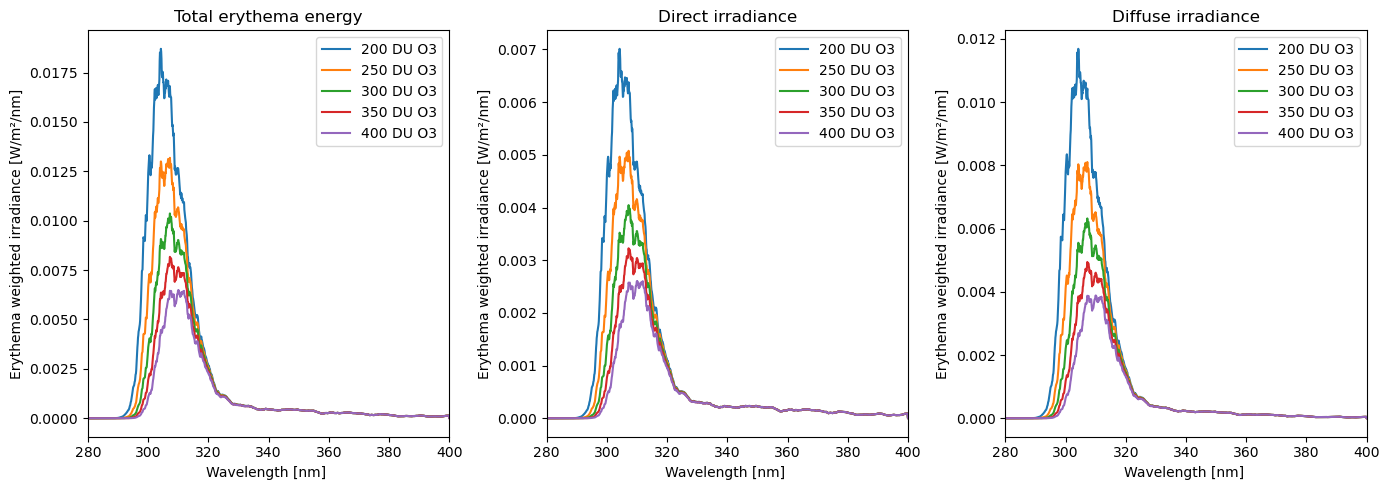

In [23]:
# Generate wavelength array from 99 to 1000 nm
wavelengths = np.arange(280, 1000.1, 0.1)

# Calculate the spectrum
spectrum = erythema_spectrum(wavelengths)

ozon_values = [200, 250, 300, 350,400]
channel_titles = ['','Total erythema energy', 'Direct irradiance', 'Diffuse irradiance']

erythem_irradiance = np.zeros_like(data)

plt.figure(figsize=(14, 5))
for c in range(3): 

    plt.subplot(1, 3, c+1)
    c = c+1
    for i in range(data.shape[0]):
        erythem_irradiance[i,:,c] = spectrum * data_trans[i,:,c]
        plt.plot(data[i,:,0],erythem_irradiance[i,:,c] , 
                label=f'{ozon_values[i]} DU O3')
    

    plt.title(f'{channel_titles[c]}')
    plt.xlim(280,400)
    plt.xlabel('Wavelength [nm] ')
    plt.ylabel('Erythema weighted irradiance [W/m²/nm]')
    plt.legend()

plt.tight_layout()
plt.show()

We can integrate these curves and find the average irradiance difference per additional percent ozon in the atmosphere. 

In [38]:
total_erythemal_irradiance = np.sum(erythem_irradiance, axis=1)[:,1]

uv_index = total_erythemal_irradiance *4

pd.set_option('display.float_format', '{:.2f}'.format)
df = pd.DataFrame(columns=['Ozone content [du]', 'Average irradiance increase %'])

for i in range(4):
    avg_ozon = np.mean(ozon_values[i:i+2])
    irradiance_diff = total_erythemal_irradiance[i]-total_erythemal_irradiance[i+1]
    diff_per_percent = irradiance_diff /(50/avg_ozon)
    df.loc[len(df)] = [avg_ozon, diff_per_percent]
    
display(df)

print('\n These findings lead to a uv index shown in the table below:')
pd.set_option('display.float_format', '{:.0f}'.format)
df_300 = pd.DataFrame(uv_index, columns=['UV index'], index= ozon_values)
df_300.index.name = 'Ozone content[du]'
display(df_300)

,Ozone content [du],Average irradiance increase %
0,225.00,3.17
1,275.00,2.45
2,325.00,1.96
3,375.00,1.61



 These findings lead to a uv index shown in the table below:


,UV index
Ozone content[du],
200,11
250,9
300,7
350,6
400,5


## Task 3 Sensitivity to precipitable water vapour
As in the last task we use the uvspec solver of libradtrans to solve for different atmospheres. In this experiment we vary the water content between 1mm and 40mm of precitable water vapor. For the solar zenit angle we use 40°, for the ozon content we use 200 du, and a surface albedo of 0.2.

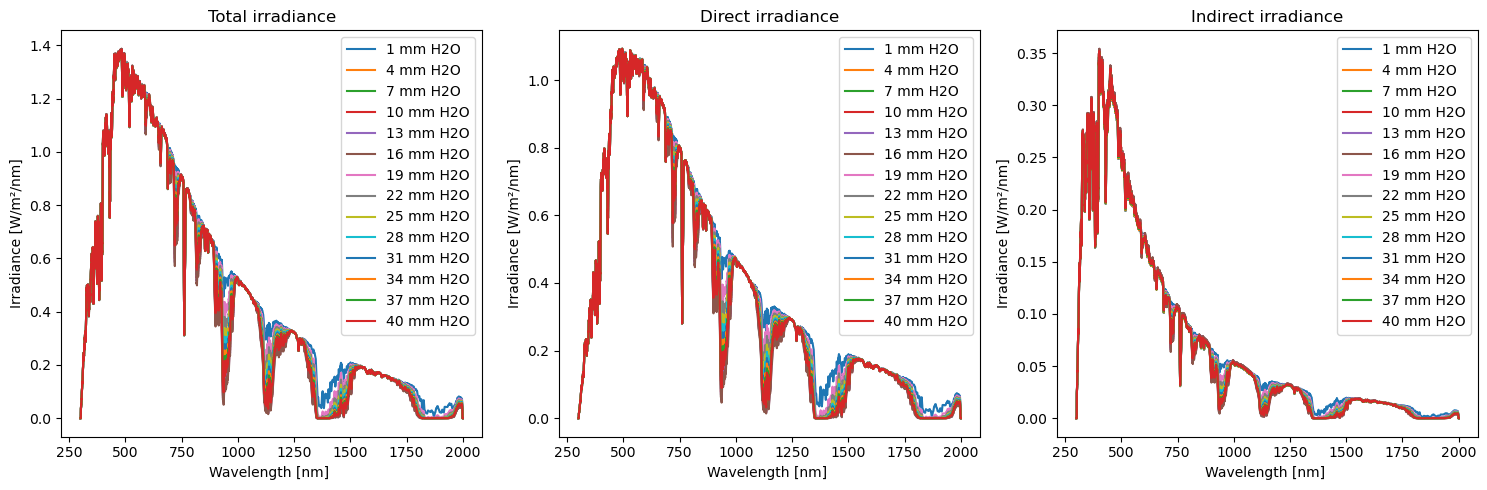

In [12]:
# Read all files
data_list = []
output_path = Path('task3/output')

for file_path in sorted(output_path.glob('*')):
    if file_path.is_file():
        # Load data from file
        data = np.loadtxt(file_path)
        data_list.append(data)

# Stack into 3D array (batch, row, column)
data = np.stack(data_list)
# adjust the unit of the values to [W/m²/nm]
data[:,:,1:4]*= 1E-3


data_trans = np.zeros_like(data)

# window size that is used to smooth the curves for better readibility.
window = 31

# Parameters for the legend and title of the plots
ozon_values = np.linspace(1,40,14)
channel_titles = ['','Total irradiance', 'Direct irradiance', 'Indirect irradiance']
plt.figure(figsize=(15, 5))

# Loop through channels
for c in range(3):
    
    plt.subplot(1, 3, c+1)
    c = c+1
    for i in range(data.shape[0]):
        # smooth the data
        data_trans[i,:,c] = np.pad(np.convolve(data[i,:,c], np.ones(window)/window, mode='valid'), 
            pad_width=int(np.floor(window/2))
        )
        plt.plot(data[i,:,0], data_trans[i,:,c], 
                label=f'{ozon_values[i]:.0f} mm H2O')
    
    plt.title(f'{channel_titles[c]}')
    plt.xlabel('Wavelength [nm] ')
    plt.ylabel('Irradiance [W/m²/nm]')
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

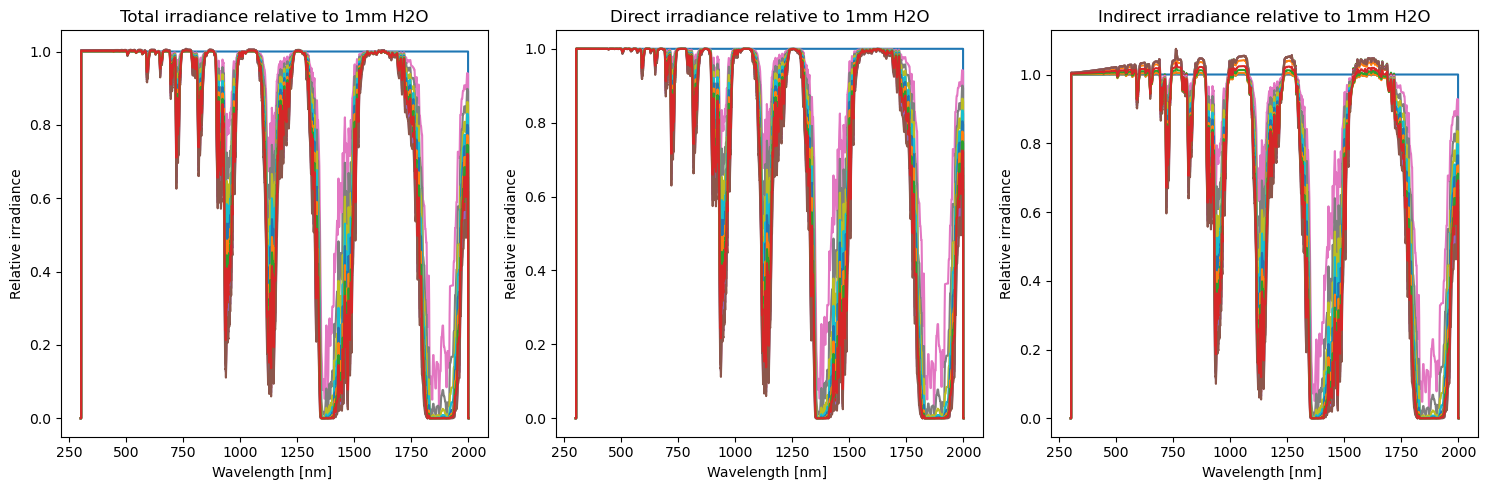

In [13]:
plt.figure(figsize=(15, 5))
channel_titles = ['','Total irradiance relative to 1mm H2O', 'Direct irradiance relative to 1mm H2O', 'Indirect irradiance relative to 1mm H2O']
for c in range(3):
    
    plt.subplot(1, 3, c+1)
    c = c+1
    for i in range(data.shape[0]):
        # smooth the data
        data_trans[i,:,c] = np.pad(np.convolve(data[i,:,c], np.ones(window)/window, mode='valid'), 
            pad_width=int(np.floor(window/2))
        )
        plt.plot(data[i,:,0], data_trans[i,:,c]/(data_trans[0,:,c]+ 0.0000000000000001), 
                label=f'{ozon_values[i]:.0f} mm H2O')
    
    plt.title(f'{channel_titles[c]}')
    plt.xlabel('Wavelength [nm] ')
    plt.ylabel('Relative irradiance')
    

plt.tight_layout()
plt.show()


We find several strong absorbtion bands from 550 nm until the end of our analysed range of 2000 nm. At 1400 nm and 1800 nm we see wide absorbtion bands at which already relatively small changes can fully absorb and lead to barely any incomming radiation. To retrive the percipitable water content we best use the absorbtion band at 900 nm or the one at 1100 nm, as they do not get desaturated and show a strong signal. Of the two the absorbtion band around 900 nm seems more usefull, as it yealds a stronger signal and has less overlap with absorbtion bands from other trance gases like methan. 

An interresting finding is that the indirrect irradiance increases with an increasing Water content. This effect is so strong that the total irradiance increases in certain regions. This is an interresting effect, as it needs additional emission. This can be either a numerical error of uvspec of some of the absorbed light gets reemitted ad a different wavelength and thereby increases irradiance in certain wavelength regions. 


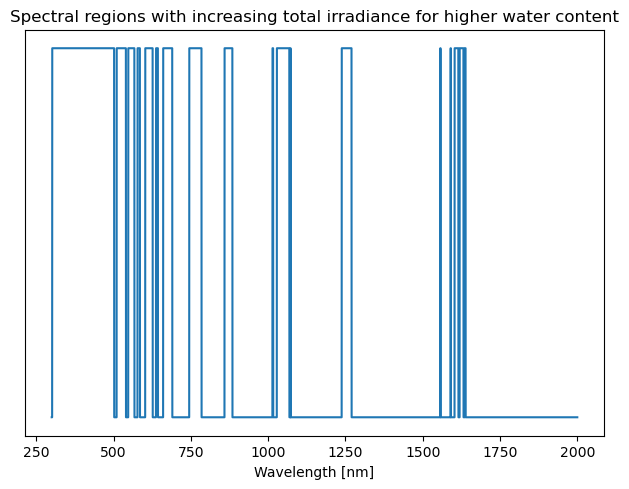

In [14]:
plt.plot(data[0,:,0], data_trans[1,:,1]/(data_trans[0,:,1]+ 0.0000000000000001) > 1)
plt.title('Spectral regions with increasing total irradiance for higher water content')
plt.tight_layout()
plt.gca().yaxis.set_visible(False)
plt.xlabel('Wavelength [nm]')
plt.show()